In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
zomato = pd.read_csv("C:/Users/ASHRITHA/Downloads/Zomato_reduced.csv", na_values = ["-", ""])

In [4]:
data = zomato.rename({"approx_cost(for two people)": "cost"}, axis=1)
data["cost"] = data["cost"].replace(",", "", regex = True)
data[["cost"]] = data[["cost"]].apply(pd.to_numeric)

In [5]:
grouped = data.groupby(["name", "address"]).agg({"listed_in(type)" : list})
newdata = pd.merge(grouped, data, on = (["name", "address"]))

In [6]:
newdata["listed_in(type)_x"] = newdata["listed_in(type)_x"].astype(str)

In [7]:
newdata.drop_duplicates(subset = ["name", "address", "listed_in(type)_x"], inplace = True)

In [8]:
newdata.index = newdata["name"]

In [28]:
newdata.drop(["name", "url", "phone", "listed_in(city)", "listed_in(type)_x", "address", "dish_liked",  "listed_in(type)_y", "menu_item", "cuisines", "reviews_list"], axis = 1, inplace = True)

,online_order,book_table,rate,votes,location,rest_type,cost
name,,,,,,,
#FeelTheROLL,No,No,3.4/5,7,Bellandur,Quick Bites,200.0
#L-81 Cafe,Yes,No,3.9/5,48,HSR,Quick Bites,400.0
#Vibes Restro,No,No,NaN,0,Electronic City,Casual Dining,700.0
#refuel,Yes,No,3.7/5,37,Bannerghatta Road,Cafe,400.0
'Brahmins' Thatte Idli,Yes,No,NaN,0,Basaveshwara Nagar,Quick Bites,100.0


In [9]:
newdata["rating"] = newdata["rate"].str[:3]
newdata.drop(["rate"], axis = 1, inplace = True)

In [10]:
newdata = newdata[newdata.rating != "NEW"]

In [11]:
newdata = newdata.dropna(subset = ["rating"])
newdata["rating"] = pd.to_numeric(newdata["rating"])

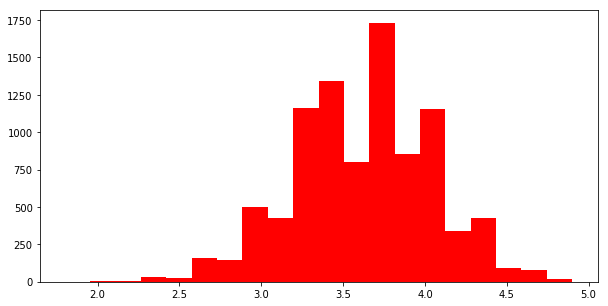

In [12]:
plt.figure(figsize = (10, 5))
plt.hist(newdata.rating, bins = 20, color = "r")
plt.show()


In [33]:
newdata["location"].value_counts()[:10]

Whitefield           617
BTM                  518
HSR                  517
Marathahalli         498
Electronic City      458
Indiranagar          435
JP Nagar             372
Bannerghatta Road    350
Jayanagar            306
Bellandur            260
Name: location, dtype: int64

In [13]:
highest_rating = (pd.DataFrame(newdata.groupby("location")["rating"].mean())).sort_values("rating", ascending = False)

In [14]:
costliest = (pd.DataFrame(newdata.groupby("location")["cost"].mean())).sort_values("cost", ascending = False)

In [15]:
newdata["rating"] = pd.cut(newdata["rating"], bins = [0, 3.0, 3.5, 4.0, 5.0], labels = ["0", "1", "2", "3"])

In [16]:
np.unique(newdata["rating"], return_counts = True)

(array(['0', '1', '2', '3'], dtype=object), array([ 884, 2929, 4037, 1466]))

In [17]:
newdata.describe(include = "all")

,name,address,listed_in(type)_x,url,online_order,book_table,votes,phone,location,rest_type,dish_liked,cuisines,cost,reviews_list,menu_item,listed_in(type)_y,listed_in(city),rating
count,9316,9316,9316,9316,9316,9316,9316.000000,9149,9316,9279,4577,9313,9284.000000,9316,9316,9316,9316,9316
unique,6512,8676,870,9316,2,2,NaN,8381,92,86,4249,2246,NaN,8964,1990,7,30,4
top,Cafe Coffee Day,Delivery Only,"['Delivery', 'Dine-out']",https://www.zomato.com/bangalore/just-bake-kor...,Yes,No,NaN,080 43334321,Whitefield,Quick Bites,Biryani,North Indian,NaN,[],[],Delivery,BTM,2
freq,49,21,872,1,5705,8393,NaN,55,617,3445,47,484,NaN,332,7314,6519,1115,4037
mean,NaN,NaN,NaN,NaN,NaN,NaN,242.149420,NaN,NaN,NaN,NaN,NaN,536.684511,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,673.984948,NaN,NaN,NaN,NaN,NaN,426.150625,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,40.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,16.000000,NaN,NaN,NaN,NaN,NaN,300.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,53.000000,NaN,NaN,NaN,NaN,NaN,400.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,191.000000,NaN,NaN,NaN,NaN,NaN,600.000000,NaN,NaN,NaN,NaN,NaN


In [39]:
predictors = newdata.drop("rating", axis = 1)
target = newdata["rating"]
X_train, X_test, y_train, y_test = train_test_split(predictors, target, random_state = 0, test_size = 0.3)


In [40]:
num_cols = ["votes", "cost"]
cat_cols = ["location", "rest_type", "online_order", "book_table"]
num_imputer = SimpleImputer(strategy = "median")
num_imputed = num_imputer.fit_transform(X_train[num_cols])
scaler = StandardScaler()
num_preprocessed = pd.DataFrame(scaler.fit_transform(num_imputed), columns = num_cols)
cat_imputer = SimpleImputer( strategy = "most_frequent")
cat_imputed = pd.DataFrame(cat_imputer.fit_transform(X_train[cat_cols]), columns = cat_cols)
cat_preprocessed = pd.DataFrame(pd.get_dummies(cat_imputed, prefix = cat_cols, drop_first = True))
train_predictors = pd.concat([num_preprocessed, cat_preprocessed], axis=1)

In [41]:
test_num_imputed = num_imputer.transform(X_test[num_cols])
test_num_preprocessed = pd.DataFrame(scaler.transform(test_num_imputed), columns = num_cols)
test_cat_imputed = pd.DataFrame(cat_imputer.transform(X_test[cat_cols]), columns = cat_cols)
test_cat_preprocessed = pd.DataFrame(pd.get_dummies(test_cat_imputed, prefix = cat_cols, drop_first = True))
test_predictors = pd.concat([test_num_preprocessed, test_cat_preprocessed], axis=1)
missing_cols = set(train_predictors) - set(test_predictors)
for c in missing_cols:
    test_predictors[c] = 0
test_predictors = test_predictors[train_predictors.columns]

In [44]:
#Decision Tree Classifier
dt = DecisionTreeClassifier()
dt.fit(train_predictors, y_train)
pred_train = dt.predict(train_predictors)
pred_test = dt.predict(test_predictors)
accuracy_score(y_train, pred_train)

0.9937126207636866

In [45]:
accuracy_score(y_test, pred_test)

0.5660107334525939

In [46]:
# Random Forest Classifier
rf = RandomForestClassifier(criterion = "gini", n_estimators = 250, max_depth = 10, 
                            max_features = 50, min_samples_split = 4, random_state = 0)
rf.fit(train_predictors, y_train)
pred_train = rf.predict(train_predictors)
pred_test = rf.predict(test_predictors)
accuracy_score(y_train, pred_train)

0.6931452231252875

In [47]:
accuracy_score(y_test, pred_test)

0.6805008944543828

In [49]:
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00       625
           1       0.85      0.64      0.73      2059
           2       0.61      0.92      0.73      2804
           3       0.86      0.62      0.72      1033

   micro avg       0.69      0.69      0.69      6521
   macro avg       0.83      0.54      0.55      6521
weighted avg       0.76      0.69      0.66      6521



In [50]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       259
           1       0.82      0.65      0.73       870
           2       0.61      0.88      0.72      1233
           3       0.78      0.58      0.66       433

   micro avg       0.68      0.68      0.68      2795
   macro avg       0.55      0.53      0.53      2795
weighted avg       0.65      0.68      0.65      2795



/home/deepak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [53]:
np.unique(pred_test, return_counts = True)

(array(['1', '2', '3'], dtype=object), array([ 688, 1788,  319]))

In [54]:
np.unique(pred_train, return_counts = True)

(array(['0', '1', '2', '3'], dtype=object), array([   1, 1544, 4226,  750]))

In [56]:
# XG Boost Classifier
xgb = XGBClassifier(n_estimators = 250, max_depth = 20, gamma = 2, learning_rate = 0.001, random_state = 0)
xgb.fit(train_predictors, y_train)
pred_train = xgb.predict(train_predictors)
pred_test = xgb.predict(test_predictors)
accuracy_score(y_train,pred_train)

0.7164545315135715

In [57]:
accuracy_score(y_test, pred_test)

0.6669051878354204